In [12]:
import json
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# --- Local Modules ---
# Dynamically add `src/` to sys.path (go up two levels)
notebook_dir = Path.cwd()
sys.path.append(str(notebook_dir.parents[1] / "src"))

from nbutils.compile_plot import compile_zne_subplots
from nbutils.zne_plot import plot_zne_result
from nbutils.summarize import summarize_zne_results
from nbutils.export_raw_data_wrapped import export_raw_data_wrapped
from nbutils.riczne import RichardsonZne

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

In [3]:
plot_colors = [
    "darkred",
    "darkgreen",
    "darkblue",
    "darkmagenta",
    "darkcyan",
    "magenta",
    "green",
    "goldenrod",
    "black",
    "orange",
    "purple"
]

In [4]:
data_dir = Path("data")
json_files = sorted(data_dir.glob("vqe-time-rel-noise-experement_*.json"))

# Load all JSONs into a list
data_list = []
for f in json_files:
    with open(f, "r") as file:
        data_list.append(json.load(file))

# Example: check first element
print(data_list[0])


{'config': {'run': 'vqe-bigT-simulation-noisy', 'bigT': [1, 5, 10, 20, 30, 40, 50, 100], 'C': 0.01, 'del_t': 0.1, 'nqubits': 5, 'state': 'dmatrix', 'output': {'file_name_prefix': 'vqe-time-rel-noise-experement_c0.01_delt0.1', 'draw': {'status': False, 'fig_dpi': 100, 'type': 'png'}}, 'observable': {'def': 'ising', 'coefficients': {'cn': [0.5, 0.5, 0.5, 0.5], 'bn': [1.0, 1.0, 1.0, 1.0, 1.0], 'r': 1}}, 'ansatz': {'layer': 20, 'gateset': 1, 'ugate': {'type': 'heisenberg', 'coefficients': {'cn': [0.5, 0.5, 0.5, 0.5], 'bn': [1.0, 1.0, 1.0, 1.0, 1.0], 'r': 0}, 'time': {'min': 0.0, 'max': 1}}}, 'vqe': {'iteration': 10, 'optimization': {'status': True, 'algorithm': 'SLSQP', 'constraint': True}}, 'init_param': {'value': 'random'}, 'noise_profile': {'status': False, 'type': 'dephasing', 'noise_prob': [0.001, 0.001, 0.0, 0.0], 'noise_on_init_param': {'status': False, 'value': 0}}, 'redundant': {'identity_factors': [[0, 0, 0, 0], [1, 1, 1, 1]]}, 'zne': {'method': 'richardson', 'degree': 1, 'sampli

In [5]:
EXACT_SOLUTION: float = -6.026674183332271
DELTA_T = 0.1
C = 0.01

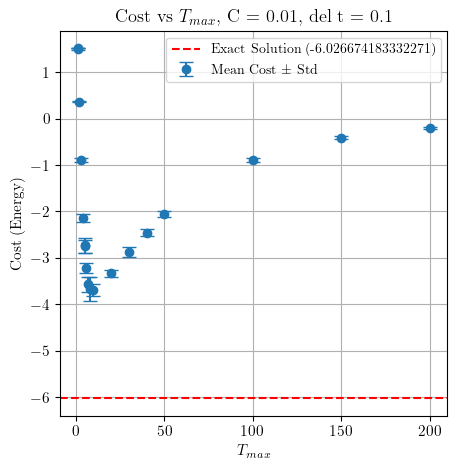

In [6]:
data_analysis = []
for data in data_list:
    temp_cost_list = data["output"]["optimized_minimum_cost"]
    t_max = data["config"]["ansatz"]["ugate"]["time"]["max"]
    cost_mean = np.mean(temp_cost_list)
    cost_std = np.std(temp_cost_list)
    data_analysis.append([[cost_mean, cost_std], t_max])

# Extract data for plotting


t_values = [item[1] for item in data_analysis]           # t_max values on x-axis
cost_means = [item[0][0] for item in data_analysis]      # mean cost
cost_stds = [item[0][1] for item in data_analysis]       # std cost

# Plot mean with std as error bars (points only, no connecting line)
plt.figure(figsize=(5,5))
plt.errorbar(t_values, cost_means, yerr=cost_stds, fmt='o', capsize=5, label='Mean Cost ± Std')

# Plot exact solution as a horizontal line
plt.axhline(y=EXACT_SOLUTION, color='red', linestyle='--', label=f'Exact Solution ({EXACT_SOLUTION})')

# Labels and title
plt.xlabel('$T_{max}$')
plt.ylabel('Cost (Energy)')
plt.title("Cost vs $T_{max}$, C = 0.01, del t = 0.1")
plt.grid(True)
plt.legend()
plt.show()
    

In [7]:
data_analysis

[[[1.5021012513707723, 0.015481027181917637], 1],
 [[-2.7314894119968485, 0.15694500246347448], 5],
 [[-3.697005112814215, 0.1331582918308029], 10],
 [[-3.3350053348493263, 0.07869829150255223], 20],
 [[-2.876999982725237, 0.09897514406662435], 30],
 [[-2.4612764655282824, 0.07104584779807369], 40],
 [[-2.0612234416401316, 0.06537019642544006], 50],
 [[-0.8894863325904208, 0.048883374934712384], 100],
 [[1.5139435580027942, 0.0020630328640671536], 1],
 [[0.36164463100130495, 0.013203802856615019], 2],
 [[-0.8938579903014621, 0.05304060720176015], 3],
 [[-2.137434774237444, 0.08874019691667848], 4],
 [[-2.7562042288795436, 0.1407804623182335], 5],
 [[-3.222536549799243, 0.1116650857472681], 6],
 [[-3.5738096239123984, 0.16007556396863817], 7],
 [[-3.6724606303746277, 0.25030068555337187], 8],
 [[-0.4097218051951937, 0.023345124389655532], 150],
 [[-0.20257524047403797, 0.011926416364037053], 200]]

In [13]:
from typing import List, Dict


def apply_richardson_adjacent_3(
    data: List[List]
) -> List[Dict]:
    """
    Apply RichardsonZne to adjacent 3-point windows.

    Input format:
        [[[mean, std], noise_param], ...]

    Output:
        List of dictionaries, one per window.
    """
    results = []

    for i in range(len(data) - 2):
        window = data[i : i + 3]

        costs = [item[0][0] for item in window]   # mean values
        noise = [item[1] for item in window]      # noise params

        zne = RichardsonZne(costs, noise)

        results.append({
            "window_index": i,
            "window_data": window,
            "costs": costs,
            "noise_param": noise,
            "zne_extrapolated_val": zne["extrapolated_val"],
            "betas": zne.get("betas"),
            "cost_richardson_zne": zne.get("cost_richardson_zne"),
        })

    return results


In [16]:
results = apply_richardson_adjacent_3(data_analysis)

for r in results:
    print(
        f"Window {r['window_index']} | "
        f"Noise param {r['noise_param']} | "
        f"ZNE = {r['zne_extrapolated_val']:.4f}"
    )

Window 0 | Noise param [1, 5, 10] | ZNE = 3.0412
Window 1 | Noise param [5, 10, 20] | ZNE = -1.0016
Window 2 | Noise param [10, 20, 30] | ZNE = -3.9630
Window 3 | Noise param [20, 30, 40] | ZNE = -4.3779
Window 4 | Noise param [30, 40, 50] | ZNE = -4.2182
Window 5 | Noise param [40, 50, 100] | ZNE = -4.6138
Window 6 | Noise param [50, 100, 1] | ZNE = 1.6356
Window 7 | Noise param [100, 1, 2] | ZNE = 2.6893
Window 8 | Noise param [1, 2, 3] | ZNE = 2.5630
Window 9 | Noise param [2, 3, 4] | ZNE = 2.9084
Window 10 | Noise param [3, 4, 5] | ZNE = 6.5857
Window 11 | Noise param [4, 5, 6] | ZNE = 1.8620
Window 12 | Noise param [5, 6, 7] | ZNE = 1.3013
Window 13 | Noise param [6, 7, 8] | ZNE = 4.1902
Window 14 | Noise param [7, 8, 150] | ZNE = -2.8356
Window 15 | Noise param [8, 150, 200] | ZNE = -3.9740


In [23]:
import numpy as np
from scipy.optimize import curve_fit

def model(t, O0, gamma):
    return O0 * np.exp(-gamma * t)


In [24]:
data = data_analysis
t = np.array([d[1] for d in data])
means = np.array([d[0][0] for d in data])
stds  = np.array([d[0][1] for d in data])

# use absolute value to avoid sign issue
y = np.abs(means)

# restrict to large T_max
mask = t >= 20
t_fit = t[mask]
y_fit = y[mask]
sigma_fit = stds[mask]


In [25]:
popt, pcov = curve_fit(
    model,
    t_fit,
    y_fit,
    p0=[y_fit[0], 0.05],   # initial guess
    sigma=sigma_fit,
    absolute_sigma=True
)

O0_fit, gamma_fit = popt
gamma_err = np.sqrt(pcov[1, 1])

print("O0 =", O0_fit)
print("gamma =", gamma_fit, "+/-", gamma_err)


O0 = 4.588176187265421
gamma = 0.015883527861081333 +/- 0.0002878776803146876


In [26]:
from scipy.stats import linregress

logy = np.log(y_fit)

res = linregress(t_fit, logy)

gamma = -res.slope
O0 = np.exp(res.intercept)


O0     = 4.527788
gamma  = 0.015754 ± 0.000272


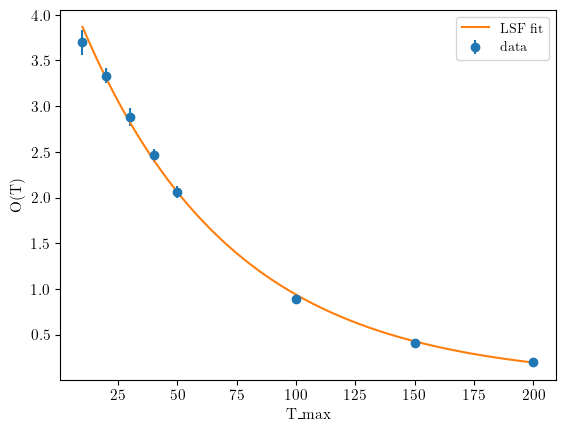

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------
# raw data
# -------------------------
data = data_analysis
# -------------------------
# extract arrays
# -------------------------
t = np.array([d[1] for d in data])
mean = np.array([d[0][0] for d in data])
std = np.array([d[0][1] for d in data])

# use absolute value (model cannot change sign)
y = np.abs(mean)

# restrict to large T_max
mask = (t >= 10) & (t <= 200)
t_fit = t[mask]
y_fit = y[mask]
sigma_fit = std[mask]

# -------------------------
# model
# -------------------------
def model(t, O0, gamma):
    return O0 * np.exp(-gamma * t)

# -------------------------
# least-squares fit
# -------------------------
popt, pcov = curve_fit(
    model,
    t_fit,
    y_fit,
    p0=[y_fit[0], 0.05],
    sigma=sigma_fit,
    absolute_sigma=True
)

O0_fit, gamma_fit = popt
gamma_err = np.sqrt(pcov[1, 1])

print(f"O0     = {O0_fit:.6f}")
print(f"gamma  = {gamma_fit:.6f} ± {gamma_err:.6f}")

# -------------------------
# plotting
# -------------------------
t_plot = np.linspace(t_fit.min(), t_fit.max(), 300)
y_plot = model(t_plot, O0_fit, gamma_fit)

plt.figure()
plt.errorbar(t_fit, y_fit, yerr=sigma_fit, fmt='o', label='data')
plt.plot(t_plot, y_plot, label='LSF fit')
plt.xlabel("T_max")
plt.ylabel("O(T)")
plt.legend()
plt.show()
